In [1]:
import gymnasium as gym
import torch
from torch import nn
from tqdm import trange
import matplotlib.pyplot as plt

# Experiment 0.0.1
I build up to a Model that learns from continous sequential actions. But it only learn from the most recent experiences. It does not remember experiences

In [2]:
env = gym.make("CartPole-v1")
def run_once(env: gym.Env, action_policy) -> int:
    """Run the environment once and return the number of episodes this ran for 

    Args:
        env (gym.Env): The gym environment
        action_policy (Callable): A callable that takes in an observation and spits out the action to take

    Returns:
        int: the number of episodes this ran for
    """
    observation, info = env.reset()
    terminated = False
    truncated = False
    episodes = 0
    reward = 0
    action = action_policy(observation, reward, episodes, False)
    while not terminated and not truncated:
        # action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        episodes += 1
        if terminated: reward = 0.0
        action = action_policy(observation, reward, episodes, terminated)
    return episodes


In [3]:
def multiple_runs(env: gym.Env, action_policy, run_count: int) -> list[int]:
    return [run_once(env, action_policy) for _ in range(run_count)]

def plot_episodes(episode_counts):
    plt.plot(episode_counts)
    plt.xlabel("run number")
    plt.ylabel("episode count")

def run_and_plot(env: gym.Env, action_policy, run_count: int) -> None:
    """Run the action policy on the environment a few times and show the length of episode in consecutive runs.

    Args:
        env (gym.Env): _description_
        action_policy (_type_): A callable that takes in the observation and the episode number
        run_count (int): number of runs to do
    """
    episode_count = [run_once(env, action_policy) for _ in range(run_count)]
    plt.plot(episode_count)
    plt.xlabel("run number")
    plt.ylabel("episode count")
    return episode_count


### Skip

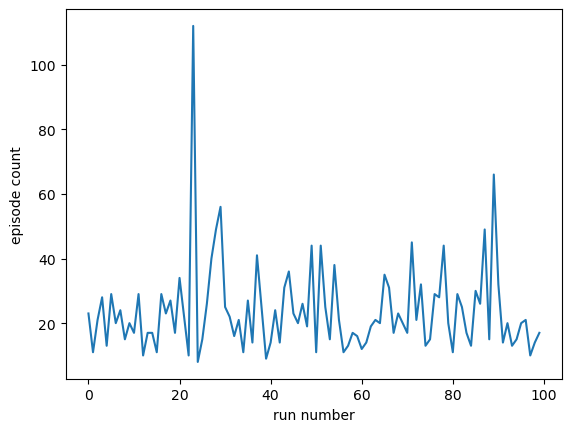

In [16]:
run_and_plot(env, lambda observation, reward, episode, terminated: env.action_space.sample(), 100)
None

In [4]:
class DQN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.stack = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )
    def forward(self, x):
        return self.stack(x)

model = DQN()
optimizer = torch.optim.AdamW(model.parameters())
with torch.no_grad():
    print(model(torch.rand(4)))

tensor([ 0.0400, -0.0214])


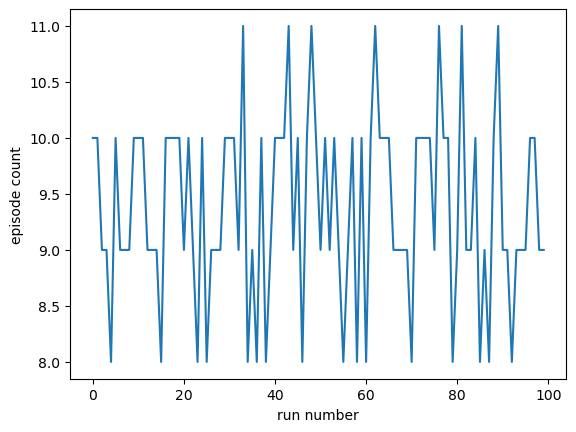

In [17]:
import numpy as np
def simple_action_policy(observations: np.ndarray, previous_reward: float, episode: int, terminated: bool):
    with torch.no_grad():
        return model(torch.from_numpy(observations)).argmax().item()
run_and_plot(env, simple_action_policy, 100)
None

### Resume

In [5]:
class DQN2(DQN):
    """This is a DQN with its own optimizer across multiple actions

    Args:
        DQN (_type_): _description_
    """
    def __init__(self, epsilon, gamma=0.9, batch_size=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.optimizer = torch.optim.AdamW(self.parameters())
        self.epsilon = epsilon
        self.gamma = gamma
        self.losses = []
        self.batch_size = batch_size
        # These histories are just to explore
        self.loss_history = []
        self.episode_history = []
        self.prediction_history = []
        self.reward_history = []
        self.lossfn = lambda a, b: (a-b)**2
    
    def act(self, observation, previous_reward, episode, terminated):
        preds = self(torch.from_numpy(observation))
        self.prediction_history.append(preds.tolist())

        action = preds.argmax().item() if torch.rand(1).item() < self.epsilon else env.action_space.sample() 
        if episode == 0:
            self.cr1 = preds[action]
        else:
            self.cr2 = preds.max()
            predicted_reward = self.cr1 - self.cr2*self.gamma
            # predicted_reward = torch.sigmoid(predicted_reward)
            self.reward_history.append(predicted_reward.item())
            error = (predicted_reward-previous_reward)
            loss = self.lossfn(predicted_reward, previous_reward)
            if terminated: loss += (preds**2).sum() # All cumilative rewards should be 0 from a state that is terminated
            self.losses.append(loss)
            self.loss_history.append(self.losses[-1].item())
            if len(self.losses) > self.batch_size:
                self.optimizer.zero_grad()
                # print(loss)
                loss.backward()
                torch.nn.utils.clip_grad_value_(self.parameters(), 100)
                self.optimizer.step()
                self.losses.clear()
            self.cr1 = preds[action]   
        return action
        

In [6]:
model = DQN2(epsilon=.1, batch_size=64, gamma=0.9)

# episodes = multiple_runs(env, model.act, 100)
# plot_episodes(episodes)
episodes = []

In [23]:
episodes += multiple_runs(env, model.act, 4000)

In [20]:
import numpy as np
def plot_model(model, episodes):
    plt.subplots(2, 2, figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.title("episode durations")
    window_size = 1
    plot_episodes(np.convolve(episodes, [1/window_size]*window_size))
    window_size = 10
    plt.subplot(2, 2, 2)
    plt.plot(np.convolve(model.loss_history, [1/window_size]*window_size), ',')
    plt.title("loss over consecutive actions")
    plt.subplot(2, 2, 3)
    plt.scatter(*zip(*model.prediction_history), s=0.1, c=(1+np.arange(len(model.prediction_history)))**0.7)
    plt.title("Cumilative reward prediction for consecutive actions")
    plt.subplot(2,2,4)
    plt.scatter(np.arange(len(model.reward_history)), model.reward_history, s=0.1)
    plt.axhline(0, linestyle='--')
    plt.axhline(1, linestyle='--')
    plt.title("reward predictions over consecitve predictions")

In [21]:
model = DQN2(epsilon=.1, batch_size=64, gamma=0.9)
episodes = []

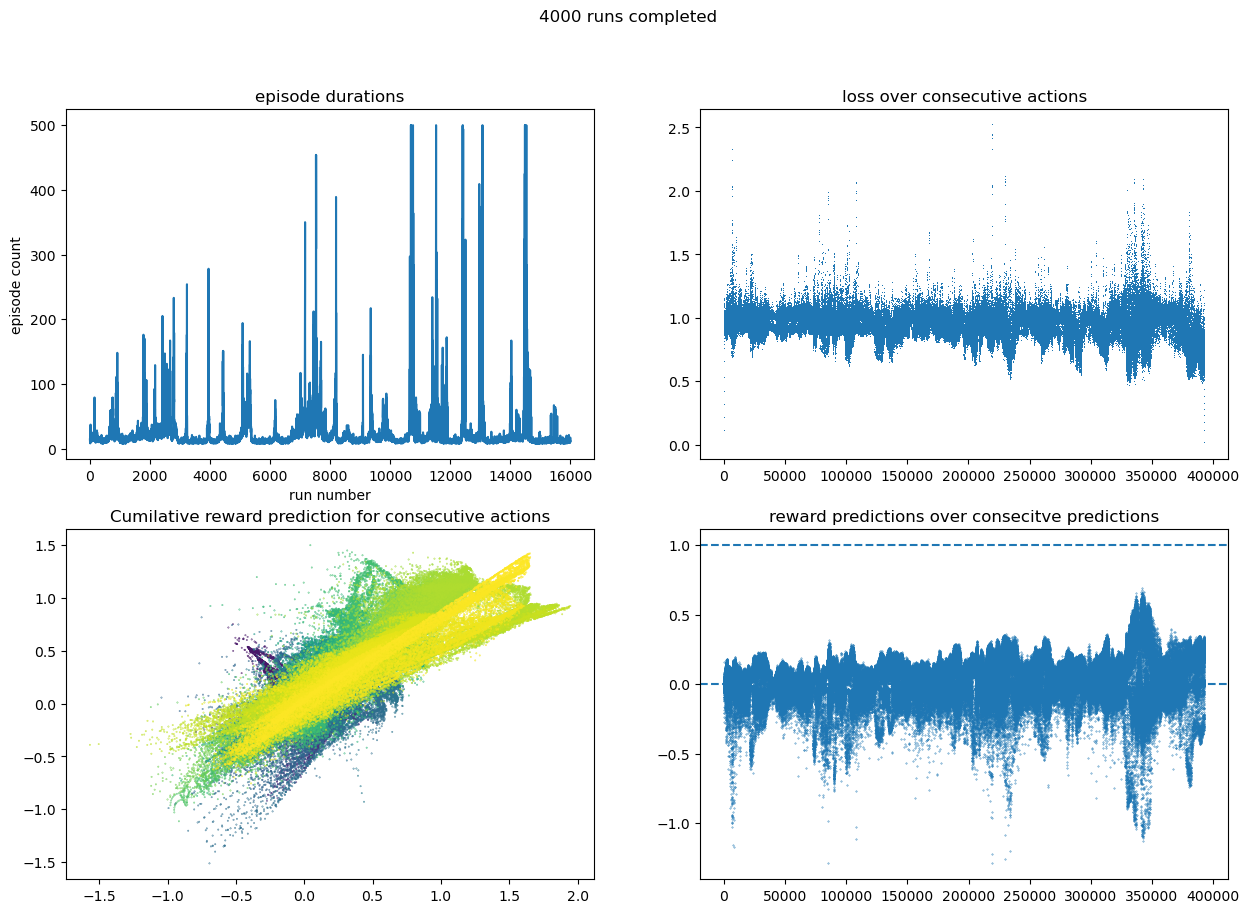

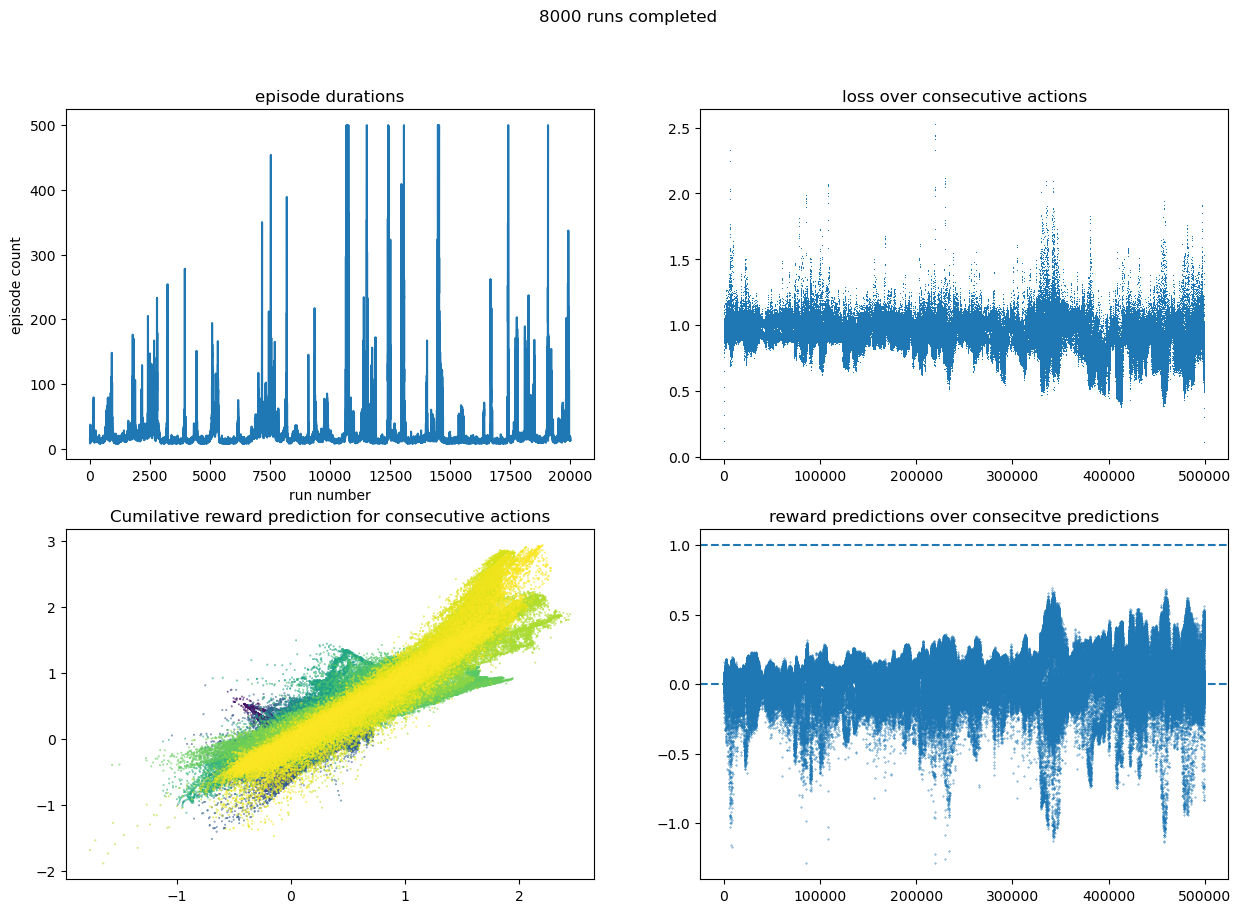

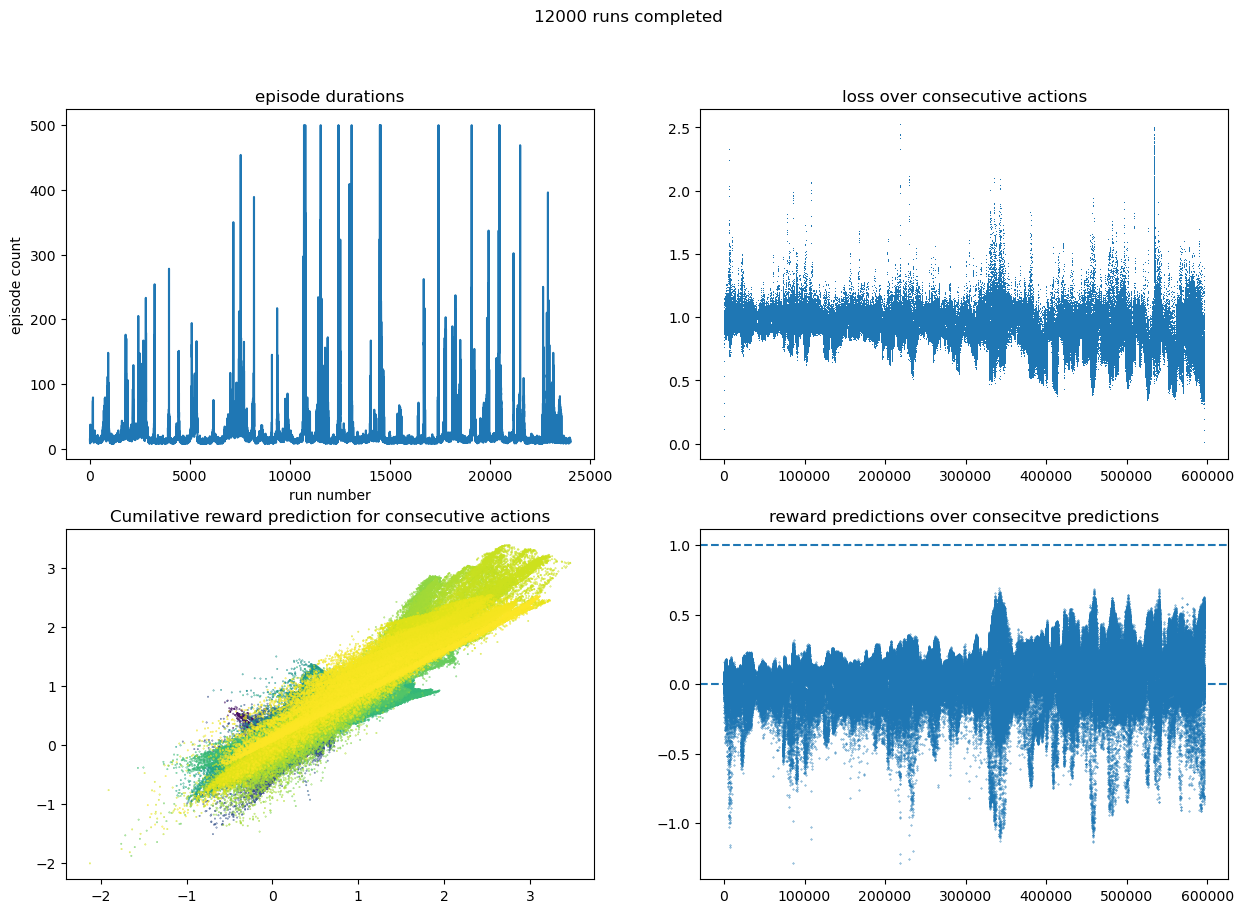

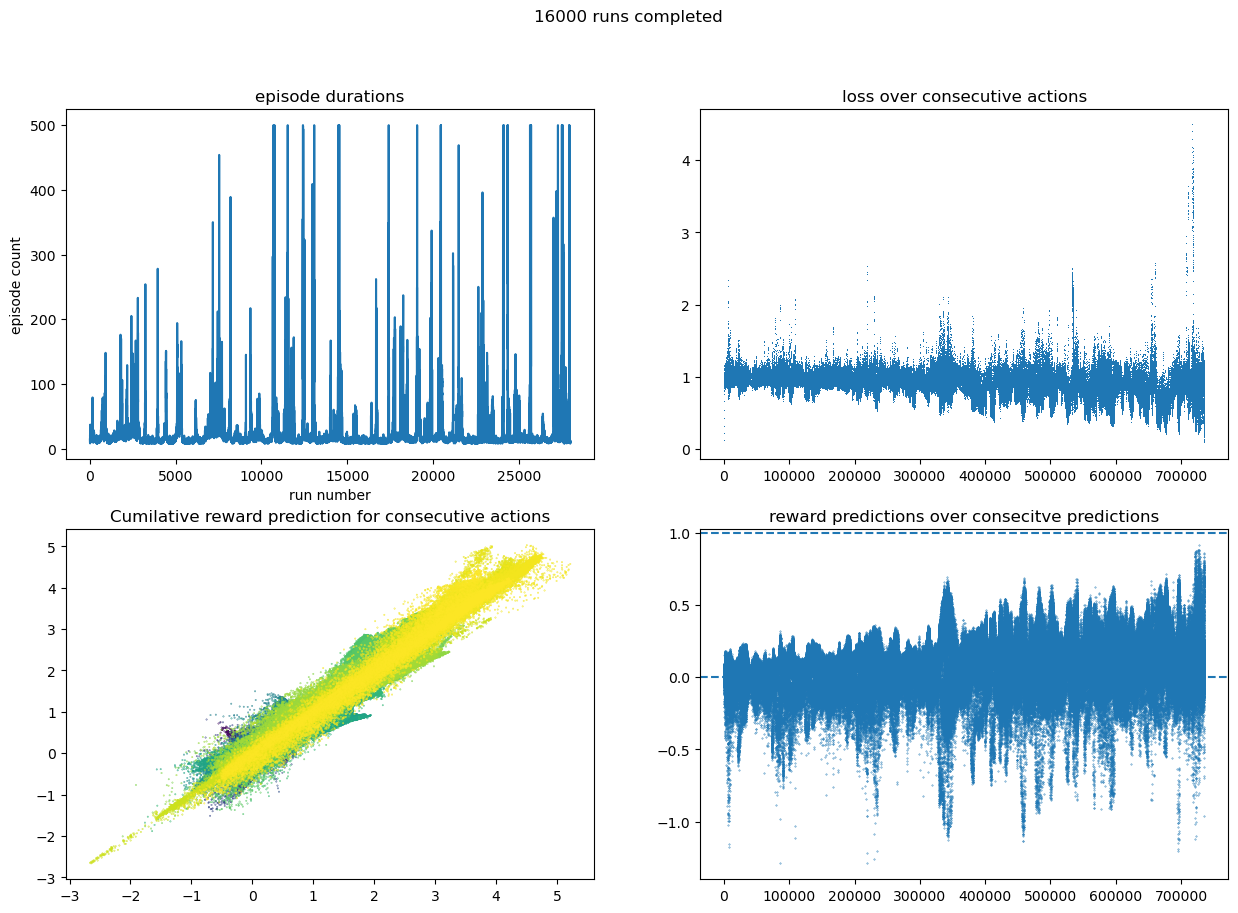

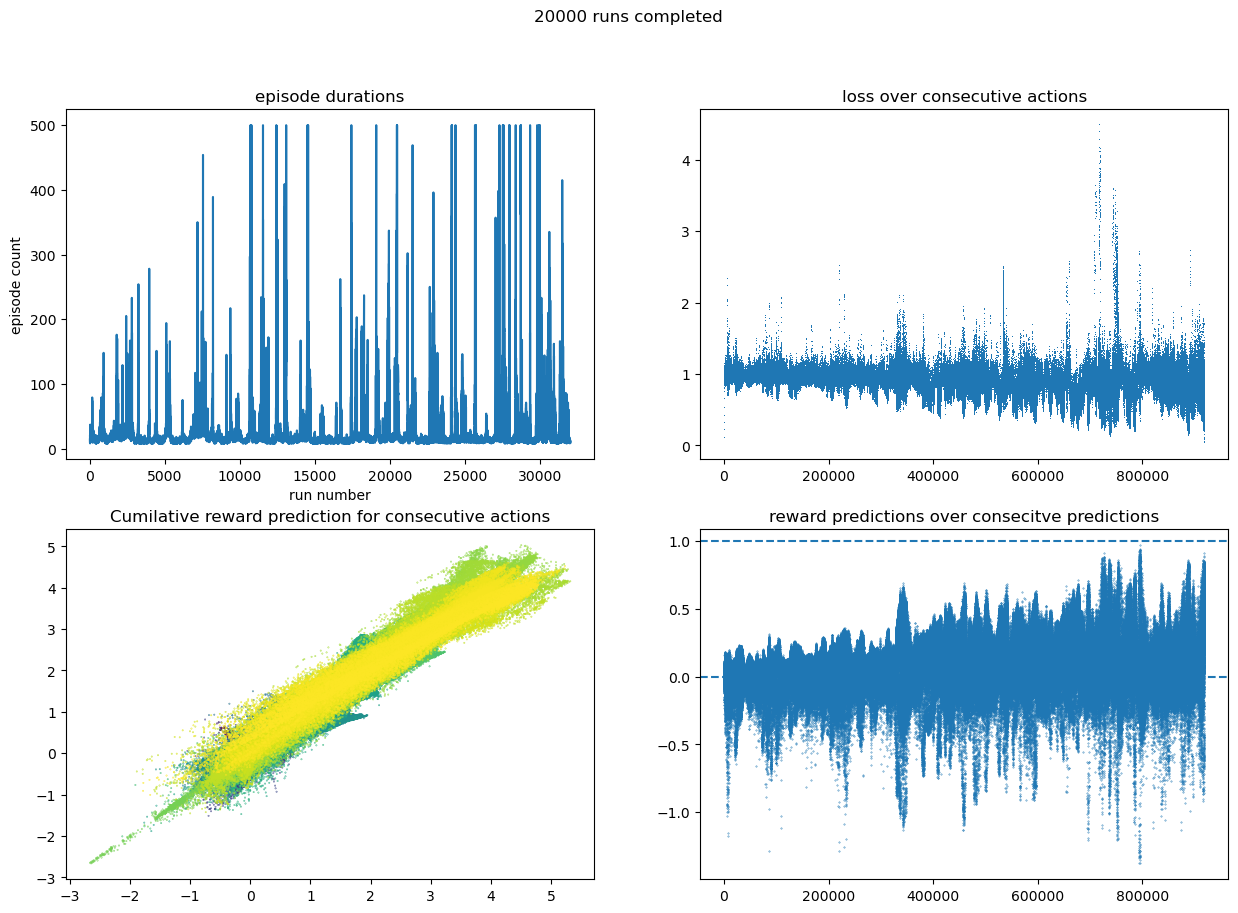

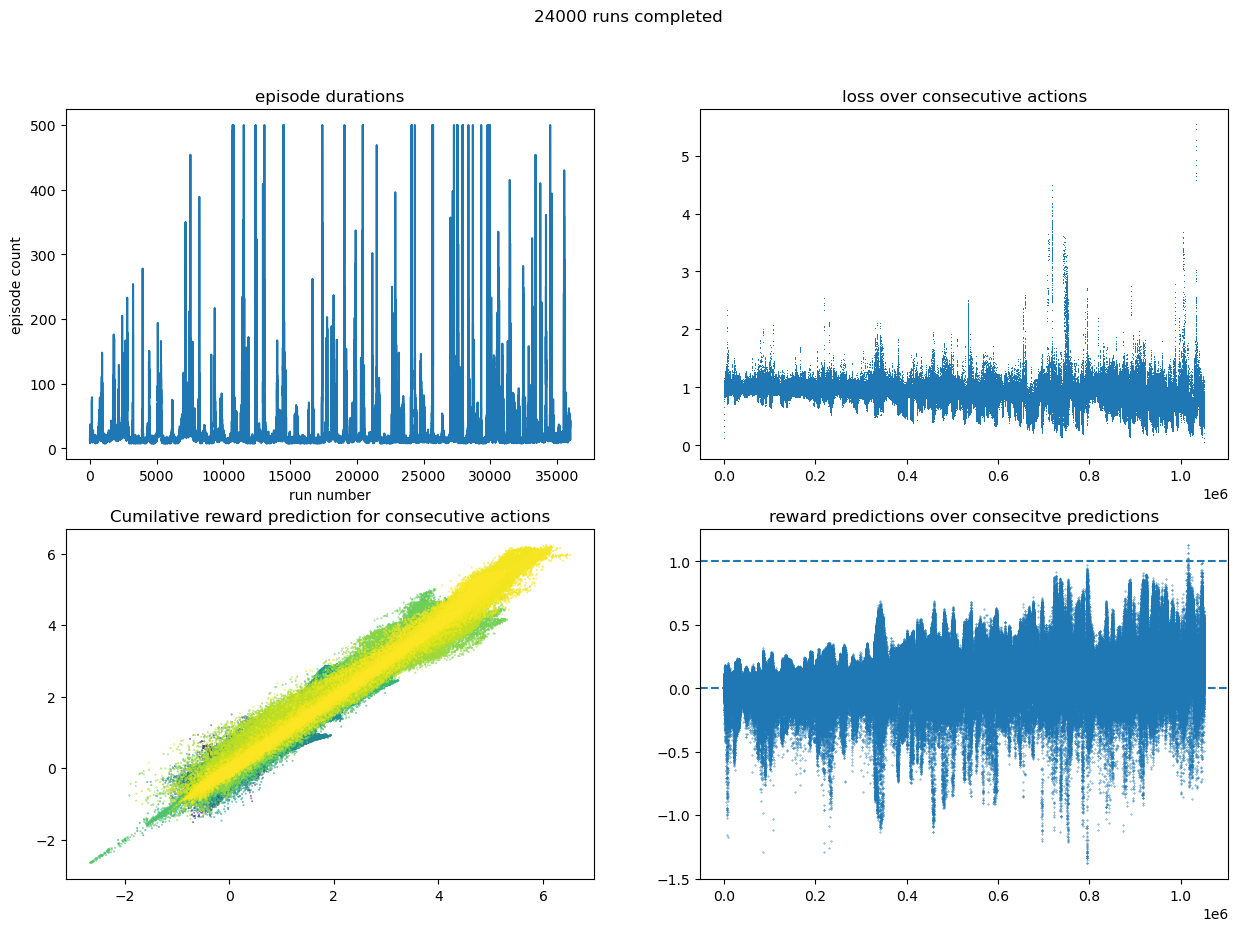

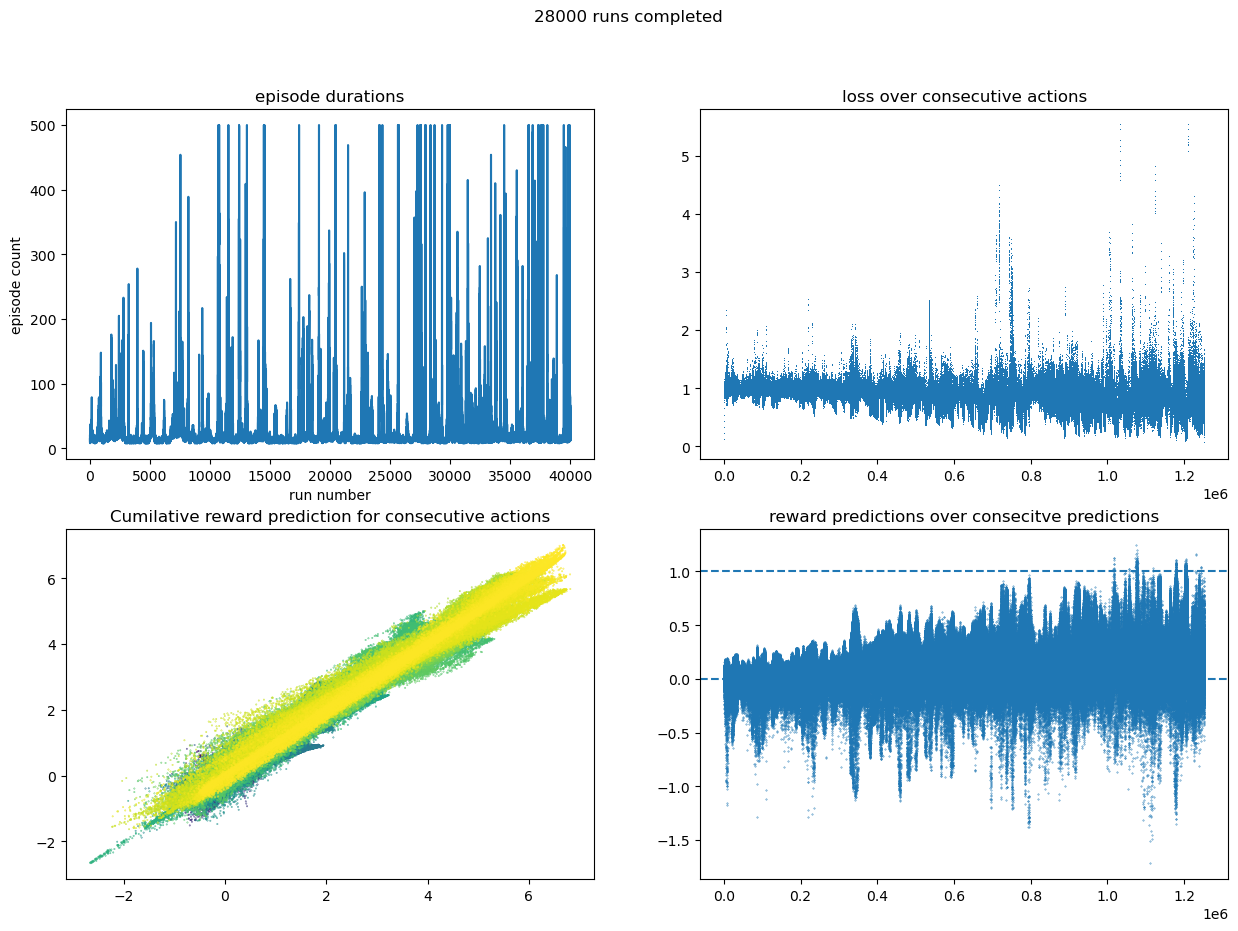

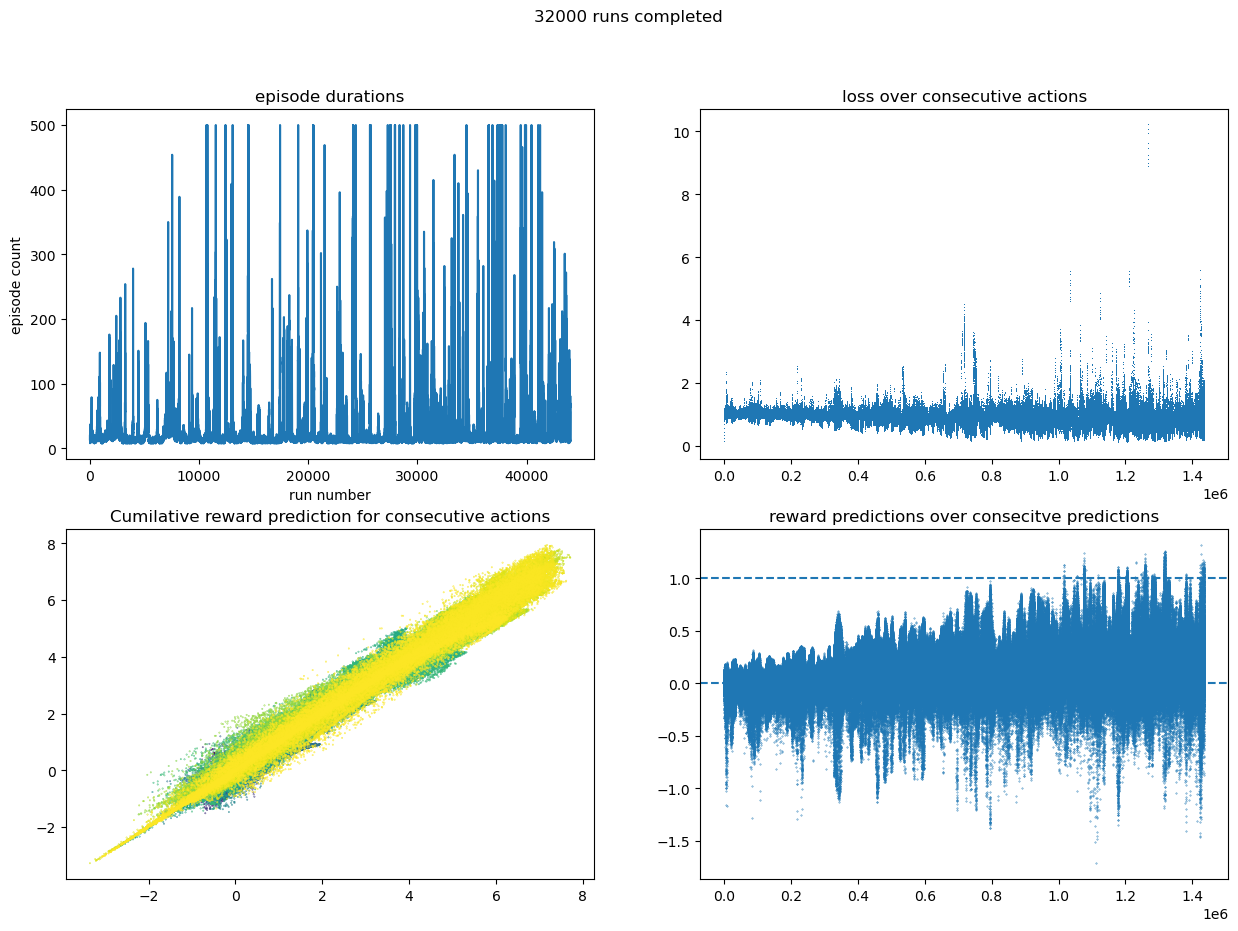

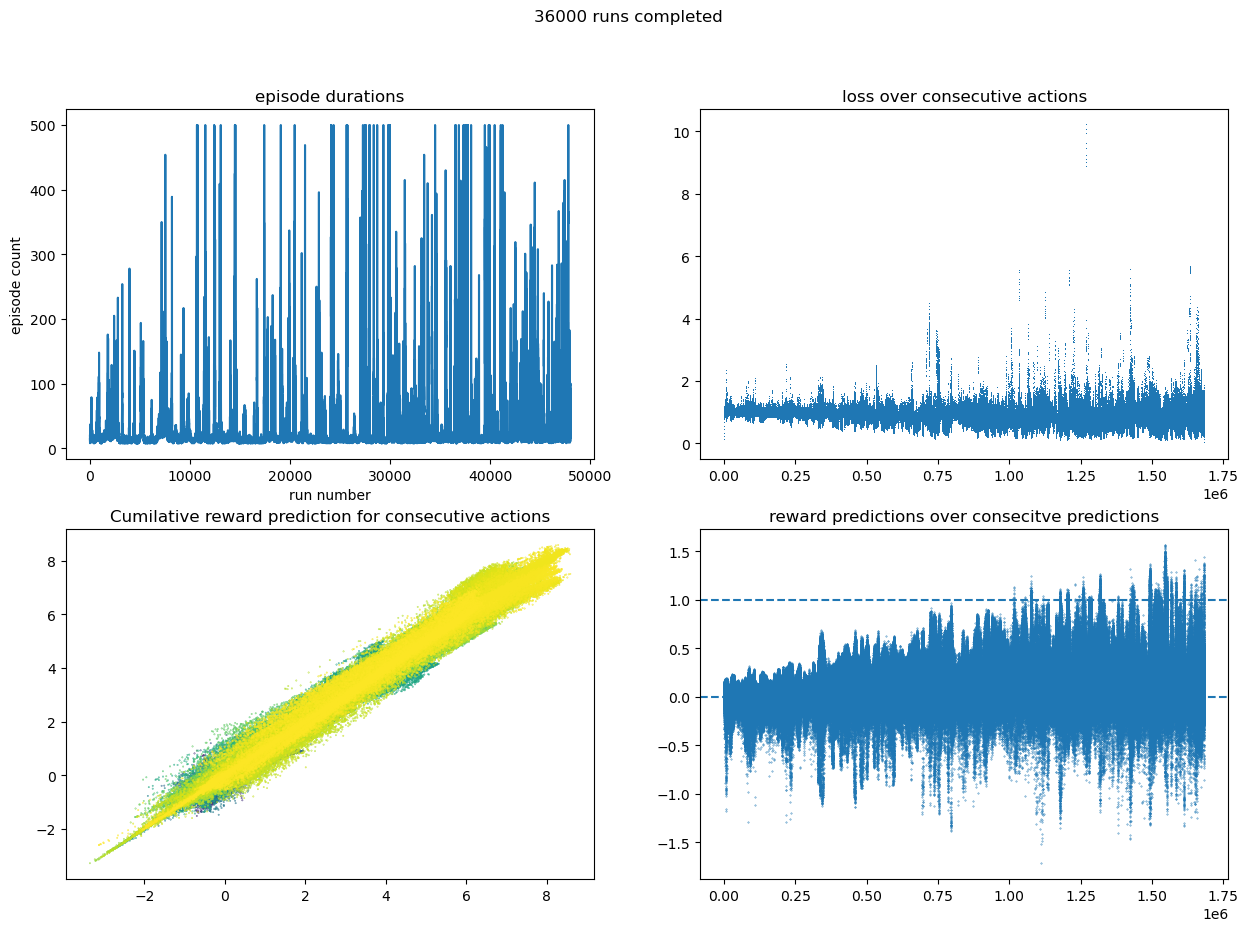

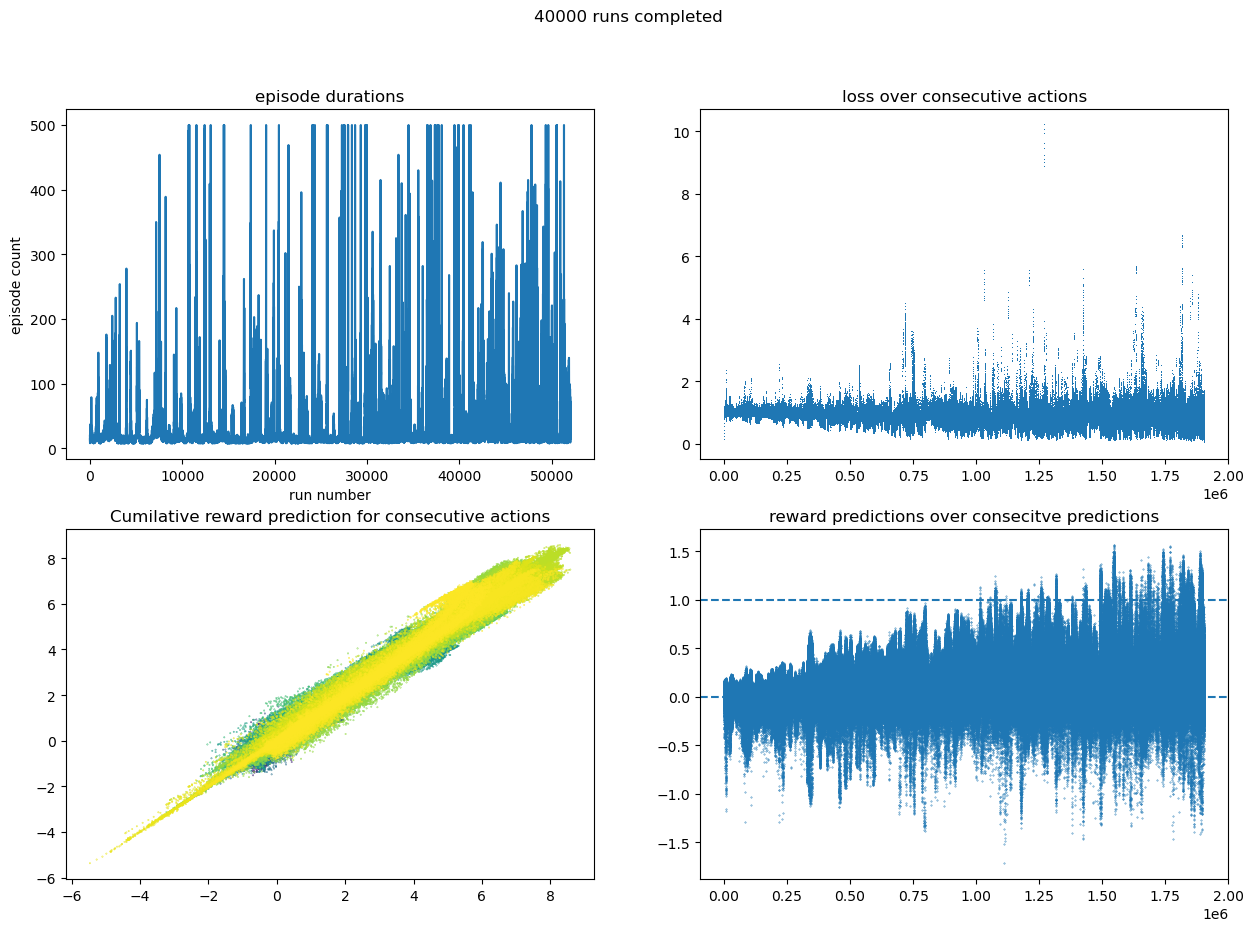

In [29]:
runs = 4000
model.gamma = 0.99
model.epsilon = 0.8
for i in range(10):
    episodes += multiple_runs(env, model.act, runs)
    plot_model(model, episodes)
    plt.suptitle(f"{runs*(i+1)} runs completed")
    plt.pause(0.1)

In [9]:
vizenv = gym.make("CartPole-v1", render_mode='human')

In [40]:
model.epsilon=1
run_once(vizenv, model.act)

17

In [41]:
vizenv.close()

hmmmm, the cumilative reward predictions appear to stabalize around the discounted cumilative sum to infinity

I'm training on only the most recent predictions
I need to train on a random sample of all the previous predictions. Not just the recent ones.